In [1]:
using ValidatedNumerics, TaylorSeries, TaylorIntegration
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false)
const λ = 1.0
const Z = 2.0
const order = 30
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000

500000

In [2]:
function undrivenHelium(τ, q)
    t, Q₁, Q₂, P₁, P₂ = q
    
    t1 = Q₁^2
    t2 = Q₂^2
    t = t1 * t2
    R12 = t1 - t2
    q₁ = 0.25*t2*P₁
    p₁ = 2Q₁*(-0.125P₂^2 + Z  - t2 - t2/abs(R12) + t*R12/abs(R12)^3)
    q₂ = 0.25*t1*P₂
    p₂ = 2Q₂*(-0.125P₁^2 + Z  - t1 - t1/abs(R12) - t*R12/abs(R12)^3)

    return [t, q₁, q₂, p₁, p₂] 

end
undrivenHelium(v) = undrivenHelium(0, v)


var1 = set_variables("t q1 q2 p1 p2", order = 1)


function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return [0, Q1, Q2, P1, P2]
end

function regHam(t, Q₁, Q₂, P₁, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = abs(Q₁² - Q₂²)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)

function errHam(N::Int)
    srand(487293456)
    J = [0 0 0 0 0; 0 0 0 1 0; 0 0 0 0 1; 0 -1 0 0 0; 0 0 -1 0 0 ]
    
    dnorm = zeros(N)
    
    for j in 1:N
        al = 10*rand(5)
        alt = al + var1
        ene = J*∇(regHam(alt))
        ene1 = [ene[k].coeffs[1].coeffs[1] for k in 1:5]
        meq = undrivenHelium(al)
        meq[1] = 0
        dnorm[j] = norm(meq - ene1) 
    end
    return dnorm  
end

errHam (generic function with 1 method)


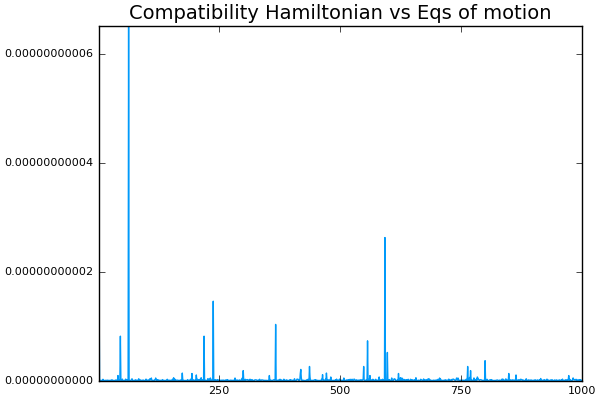

In [3]:
dnorm = errHam(1_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")

In [4]:
maximum(dnorm)

6.507814330688532e-11

In [5]:
function q2sign(xold, x0, tol)
    if abs(xold[3]) < tol
        sq2o = 0
    else
        sq2o = sign(xold[3])
    end
    
    if abs(x0[3]) < tol
        sq2 = 0
    else
        sq2 = sign(x0[3])
    end
    if abs(xold[5]) < tol
        sp2o = 0
    else
        sp2o = sign(xold[5])
    end
    
    if abs(x0[5]) < tol
        sp2 = 0
    else
        sp2 = sign(x0[5])
    end
    return sq2o, sq2, sp2o, sp2
end
    

q2sign (generic function with 1 method)

In [6]:
###Implementamos nuevo código 
function taylorstep1!{T<:Number}(f, t0::T, t1::T, x0::Array{T,1},
        order::Int, abstol::T)
    @assert t1 > t0
    # Initialize the vector of Taylor1 expansions
    xT = Array{Taylor1{T}}(length(x0))
    for i in eachindex(x0)
        @inbounds xT[i] = Taylor1( x0[i], order )
    end

    # Compute the Taylor coefficients
    TaylorIntegration.jetcoeffs!(f, t0, xT)

    # Compute the step-size of the integration using `abstol`
    δt = TaylorIntegration.stepsize(xT, abstol)
    δt = min(δt, t1-t0)

    evaluate!(xT, δt, x0)
    return δt, xT
end


function mytaylorinteg{T<:Number}(f, q0::Array{T,1}, order::Int, abstol::T, t0::T, 
    tmax::T; tsteps::Int = 1000, tol::Float64=1e-20, maxsteps::Int=5000)

    # Allocation
    tv = Array{T}(maxsteps)
    dof = length(q0)
    xv = Array{T}(dof, maxsteps)

   
    # Initial conditions
    @inbounds tv[1] = t0
    @inbounds xv[:,1] = q0[:]
    x0 = copy(q0)

    # Integration
    nsteps = 1
    while t0 < tmax
        xold = copy(x0)
        δt, sT = taylorstep1!(f, t0, tmax, x0, order, abstol)
        sq2o, sq2, sp2o, sp2 = q2sign(xold, x0, tol)
        steps1 = 0
        x00 = copy(x0)
        while sq2o*sq2 == -1 || (sp2o*sp2 == -1 && abs(xold[3]) < tol)
            q2T = sT[3]
            dq2T = derivative(q2T)
            δtn = copy(δt)
            for nc in 1:20
                δtn = δtn - evaluate(q2T, δtn)/evaluate(dq2T, δtn)
            end
            δt = minimum([δtn, δt])
            evaluate!(sT, δt, x0)
            sq2o, sq2, sp2o, sp2 = q2sign(xold, x0, tol)
            steps1 += 1
            if steps1  ≥ tsteps
                break
            end
        end
        t0 += δt
                
        if nsteps ≥ maxsteps 
            warn("""
            Maximum number of integration steps reached; exiting.
            """)
            break
        end
        nsteps += 1
        @inbounds tv[nsteps] = t0
        @inbounds xv[:,nsteps] = x0[:]
    end

    return view(tv,1:nsteps), view(xv,:,1:nsteps)'
end

mytaylorinteg (generic function with 1 method)

In [7]:
c1 = condini(2.0, 0.0)

5-element Array{Float64,1}:
 0.0    
 1.41421
 0.0    
 0.0    
 4.0    

In [8]:
t, x = mytaylorinteg(undrivenHelium, c1, order, abs_tol, t0, 15.0)

([0.0,0.170169,0.293022,0.389814,0.467347,0.530049,0.584848,0.629127,0.668293,0.704756  …  12.6114,12.6118,12.6123,12.6127,12.6131,12.6136,12.614,12.6144,12.6148,12.6153],
[0.0 1.41421 … 0.0 4.0; 0.0130626 1.41421 … -0.00855838 3.9387; … ; 3292.75 48.257 … 67.932 -4.0; 3293.04 48.2591 … 67.935 -2.83647])

In [9]:
ene = zeros(t)
for j in eachindex(ene)
    ene[j] = abs(regHam(x[j,:]))
end

In [10]:
ene

5000-element Array{Float64,1}:
 0.0        
 7.21645e-16
 2.22045e-16
 4.44089e-16
 4.44089e-16
 4.44089e-16
 0.0        
 0.0        
 8.88178e-16
 0.0        
 1.77636e-15
 1.77636e-15
 0.0        
 ⋮          
 3.18323e-12
 4.3201e-12 
 4.54747e-12
 3.86535e-12
 5.00222e-12
 5.00222e-12
 4.54747e-12
 4.09273e-12
 2.27374e-12
 1.81899e-12
 1.81899e-12
 2.27374e-12


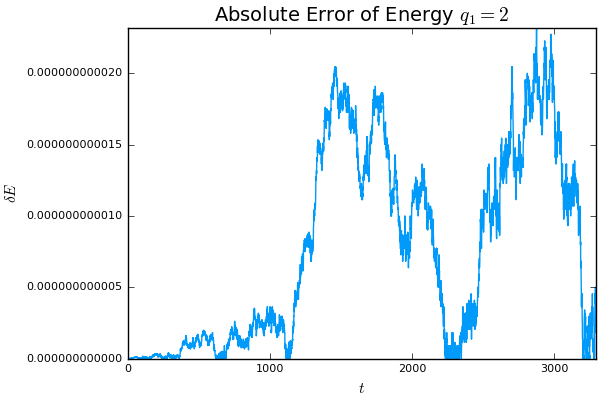

In [11]:
plot(x[:,1], ene, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [12]:
maximum(ene)

2.319211489520967e-11

In [13]:
function psundriven(x10::Float64, px10::Float64, tol::Float64 = 1e-20)
    c1 = condini(x10, px10)
    t, x = mytaylorinteg(undrivenHelium, c1, order, abs_tol, t0, 15.0)
    ps = zeros(x)
    ts = zeros(t)
    count = 0
    for j in eachindex(ts)
        if abs(x[j,3]) < tol
            count += 1
            ts[count] = t[j]
            ps[count, :] = x[j, :]
        end
    end
    return ts[1:count], ps[1:count, :]
end

psundriven (generic function with 2 methods)

In [21]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreq(n::Int) = Symbol( string("q", n) )

function orbits(rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = 1:N
        ex = quote 
                $(nombret(j)), $(nombreq(j)) = 
                psundriven(Float64($(rs[j])), 0.0) 
             end
        eval(ex)  
    end
end

orbits (generic function with 2 methods)

In [15]:
function ksv(Q, P)
    v₁ = P/Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [22]:
orbits()

In [23]:
xs1 = map(ks, q1[:,2])
vxs1 = Float64[ksv(q1[j,2], q1[j, 4]) for j in eachindex(t1)]
xs2 = map(ks, q2[:,2])
vxs2 = Float64[ksv(q2[j,2], q2[j, 4]) for j in eachindex(t2)]
xs3 = map(ks, q3[:,2])
vxs3 = Float64[ksv(q3[j,2], q3[j, 4]) for j in eachindex(t3)]
xs4 = map(ks, q4[:,2])
vxs4 = Float64[ksv(q4[j,2], q4[j, 4]) for j in eachindex(t4)]
xs5 = map(ks, q5[:,2])
vxs5 = Float64[ksv(q5[j,2], q5[j, 4]) for j in eachindex(t5)]
xs6 = map(ks, q6[:,2])
vxs6 = Float64[ksv(q6[j,2], q6[j, 4]) for j in eachindex(t6)]
xs7 = map(ks, q7[:,2])
vxs7 = Float64[ksv(q7[j,2], q7[j, 4]) for j in eachindex(t7)]
xs8 = map(ks, q8[:,2])
vxs8 = Float64[ksv(q8[j,2], q8[j, 4]) for j in eachindex(t8)]
xs9 = map(ks, q9[:,2])
vxs9 = Float64[ksv(q9[j,2], q9[j, 4]) for j in eachindex(t9)];


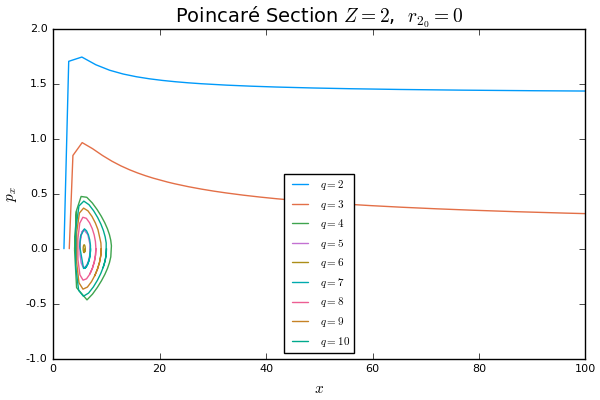

In [27]:
plot(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$", legend =:true)
plot!(xs2, vxs2, label = L"q = 3")
plot!(xs3, vxs3, label = L"q = 4")
plot!(xs4, vxs4, label = L"q = 5")
plot!(xs5, vxs5, label = L"q = 6")
plot!(xs6, vxs6, label = L"q = 7")
plot!(xs7, vxs7, label = L"q = 8")
plot!(xs8, vxs8, label = L"q = 9")
plot!(xs9, vxs9, label = L"q = 10")
xaxis!([0,20])
xlabel!(L"x")
ylabel!(L"p_x")
yaxis!([-1,2])
xaxis!([0,100])